Harshit Agrawal

$$\pagebreak$$

# Exercise on Convolutional Neural Networks 

<p>In this exercise you will extend and improve the accuracy of the Convolution Neural Network discussed in the demonstration by doing the following things: </p>
<ul>
<li>Creating a deep Convolutional Neural Network.</li>
<li>Tweaking the hyper-parameters such as the number of channels in each layer, activation functions, mini batch size, etc;</li>
</ul>
<p>The architecture of the network that we will create is similar to the figure below (This figure will not be displayed when exported to .pdf):</p>

<img src="https://i.imgur.com/AjQYgPv.png" alt="Demo Architecture" title="Figure 1" width="500" />

<p>We will begin by first importing the necessary python libraries:</p>

In [1]:
import os
import csv
import six.moves.cPickle as pickle
import gzip
import numpy
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import random as rd
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from exercise_helper import load_data, pooling, convLayer
from exercise_helper import fullyConnectedLayer
from exercise_helper import negative_log_lik, errors
from exercise_helper import generate_plot
from numpy import genfromtxt
%matplotlib inline
# Setting the random number generator
rng = numpy.random.RandomState(23455)
print('***** Import complete *****')

***** Import complete *****


<p><b>Note: If the import of 'exercise_helper' fails, ensure that 'exercise_helper.py' is in the same folder as this notebook.</b>

<p>Now we can create the Theano Computation Graph. We shall partition the data into mini-batches and then create a computation graph for training, validation and testing. The overall logic is very similar to the demonstration. Refer to the demonstration for more details.</p>

In [22]:
def train_test_conv_net(learning_rate, num_epochs,
                        num_filters, mini_batch_size, activation):
    # Function to create the convolutional neural network, train and
    # evaluate it. This function must be called to run the network.
    
    # Inputs:
    # learning_rate - Learning rate for Stochastic Gradient Descent
    # num_epochs - Number of training epochs
    # num_filters - Number of kernels for each convolution layer
    #               for e.g. 2 layers - [20, 50]. 
    #.              layer1 = 20, layer2 = 50
    # mini_batch_size - Mini-batch size to be used
    # activation - Activation function to use
    
    # Outputs:
    # Plot of the cost, prediction errors on validation set and
    # visualisation of weights of the first convolutional layer
    
    # Partitioning into mini- batches
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches //= mini_batch_size
    n_valid_batches //= mini_batch_size
    n_test_batches //= mini_batch_size

    print('train: %d batches, test: %d batches,'
          ' validation: %d batches'
          % (n_train_batches, n_test_batches, n_valid_batches))
    
    mb_index = T.lscalar() # mini-batch index
    x = T.matrix('x') # rasterised images
    y = T.ivector('y') # image labels
    layer_weights = [];
    print('***** Constructing model ***** ')

    # Reshaping matrix of mini_batch_size set of images into a 
    # 4-D tensor 
    layer0_input = x.reshape((mini_batch_size, 1, 28, 28))

    

    # Construct first convolution and pooling layer
    # Hint: Use the convLayer function. See demonstration.

    [layer0_output, layer0_params] = convLayer(
        rng,
        data_input=layer0_input,
        image_spec=(mini_batch_size, 1, 28, 28),
        filter_spec=(num_filters[0], 1, 5, 5),
        pool_size=(2, 2),
        activation=activation)




    # Construct second convolution and pooling layer
    # Hint: Use the convLayer function. See demonstration.


    [layer1_output, layer1_params] = convLayer(
        rng,
        data_input=layer0_output,
        image_spec=(mini_batch_size, 9, 12, 12),
        filter_spec=(num_filters[1], 9, 5, 5),
        pool_size=(2, 2),
        activation=activation)



    # Classify the values using the fully-connected
    # activation layer.
    # Hint: Remember to flatten the output from the 
    # convolutional layer. Use the fullyConnectedLayer function.
    # See demonstration.

    fc_layer_input = layer1_output.flatten(2)

    [p_y_given_x, y_pred, fc_layer_params] = fullyConnectedLayer(
        data_input=fc_layer_input,
        num_in=num_filters[2]*4*4,
        num_out=10)


    ##########################################################

# Cost that is minimised during stochastic descent.
    cost = negative_log_lik(y=y, p_y_given_x=p_y_given_x)

    # Creating a function that computes the mistakes on the test set
    # mb_index is the mini_batch_index
    test_model = theano.function(
        [mb_index],
        errors(y, y_pred),
        givens={
            x: test_set_x[
                mb_index * mini_batch_size:
                (mb_index + 1) * mini_batch_size],
            y: test_set_y[
                mb_index * mini_batch_size:
                (mb_index + 1) * mini_batch_size]})

    # Creating a function that computes the mistakes on the validation
    # set
    valid_model = theano.function(
        [mb_index],
        errors(y, y_pred),
        givens={
            x: valid_set_x[
                mb_index * mini_batch_size:
                (mb_index + 1) * mini_batch_size],
            y: valid_set_y[
                mb_index * mini_batch_size:
                (mb_index + 1) * mini_batch_size]})
    

    # Create list of parameters to fit during training.
    # Hint: Include the parameters from the two convolution layers
    # and activation layer
    
    params = fc_layer_params + layer1_params + layer0_params
    
    ##########################################################
    
    # Creating a list of gradients
    grads = T.grad(cost, params)

    # Creating a function that updates the model parameters by SGD.
    # The updates list is created by looping over all 
    # params[i], grads[i]) pairs.
    updates = [(param_i, param_i - learning_rate * grad_i)
               for param_i, grad_i in zip(params, grads)]

    train_model = theano.function(
        [mb_index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[
                mb_index * mini_batch_size:
                (mb_index + 1) * mini_batch_size],
            y: train_set_y[
                mb_index * mini_batch_size:
                (mb_index + 1) * mini_batch_size]})

    epoch = 0
    cost_arr = numpy.array([])
    valid_score_arr = numpy.array([])
    valid_score_arr = numpy.append(valid_score_arr, 1)

    print('***** Training model *****')
    if (num_epochs < 1):
        print("Too few epochs!")
        return
    while (epoch < num_epochs):
        epoch = epoch + 1
        print("Training in epoch: %d / %d" % (epoch, num_epochs),
              end='\r')
        for minibatch_index in range(n_train_batches):
            # Computing number of iterations performed or total number
            # of mini-batches executed.
            iter = (epoch - 1) * n_train_batches + minibatch_index
            # cost of each minibatch
            cost_ij = train_model(minibatch_index)
            cost_arr = numpy.append(cost_arr, cost_ij)

        # Computing loss on each validation mini-batch after each epoch
        valid_losses = [valid_model(i) for i in range(n_valid_batches)]
        valid_score_arr = numpy.append(
                                       valid_score_arr,
                                        numpy.mean(valid_losses))
    print('***** Training Complete *****')
    # Computing mean error rate on test set
    test_losses = [test_model(i) for i in range(n_test_batches)]
    test_score = numpy.mean(test_losses)
    print('Prediction error: %f %%' % (test_score * 100.))
    # Generating the plots
    generate_plot(cost_arr, range(1, iter+2),
                  valid_score_arr,
                  range(0, epoch+1),
                  layer0_params[0].get_value())

### Experiment

<p>Now we shall define some hyper-parameters and evaluate the model. We will compute the final Prediction Error on the test set. To complete this assignment, you must do the following things:</p>
<ol>
<li>Set your parameters in the cell below</li>
<li>Run the experiment. Then, describe and discuss it in the 'Conclusions' cell below. You must do this for each experiment that you run.</li>
<li>Especially in CSC notebooks, do not forget to restart the kernel after each experiment.</li>
<li>Repeat from step 1 and perform at least 4 experiments.</li>
<li>Run the experiment with the best result again to display the plots in the final submission.</li>
<li>Download the completed assignment as PDF and submit as usual. The final PDF will contain the plots from only your best experiment as well as the discussion of all your experiments in the 'Conclusions' cell.</li>
</ol>


***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 120 batches, test: 40 batches, validation: 40 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 3.100000 %


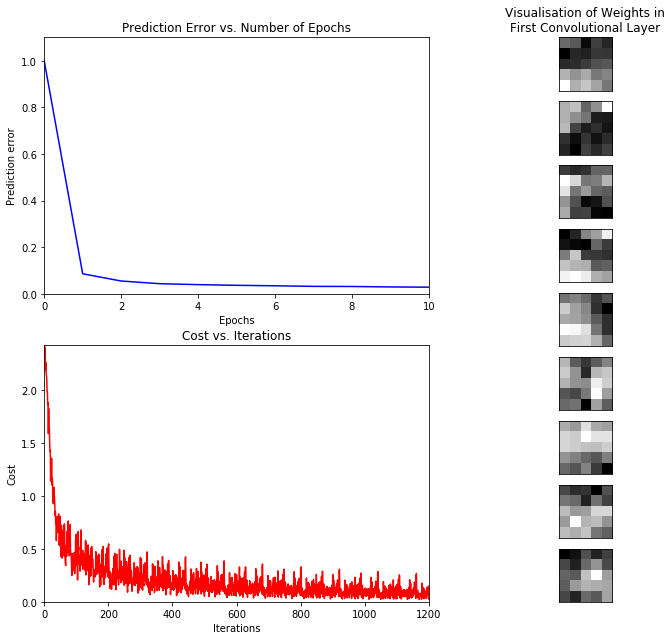

In [16]:


# Description and examples of parameters to train_test_conv_net()

# learning_rate - Sets the learning rate for Stochastic Gradient
#                 Descent. e.g.: 0.1
# num_epochs - Sets the number of training epochs. E.g.: 10
# num_filters - Sets the number of kernels for each 
#               convolution layer. for e.g. 2 layers: [4, 8]
#               implies layer1 = 4, layer2 = 8
# mini_batch_size - Sets the mini-batch size to be used in 
#                   the experiment. E.g: 50
# activation - Sets the activation function to be used.
#              E.g.: T.tanh
# train_size - Sets the number of training samples to be used.
#              E.g. 6000. 

# Note: The Kernel may crash on too large values of the 
# num_epochs, num_filters, mini_batch_size and train_size due to 
# memory limitations. This may happen especially on CSC notebooks
# as it is a shared resource.
# If that happens use smaller values!

learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 50
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

<p>Now go ahead and experiment with different hyper-parameters such as different number of filters, different number of convolution layers, activation functions etc;. Try to find out which configuration gives the best accuracy.</p>

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 40 batches, test: 13 batches, validation: 13 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 5.487179 %


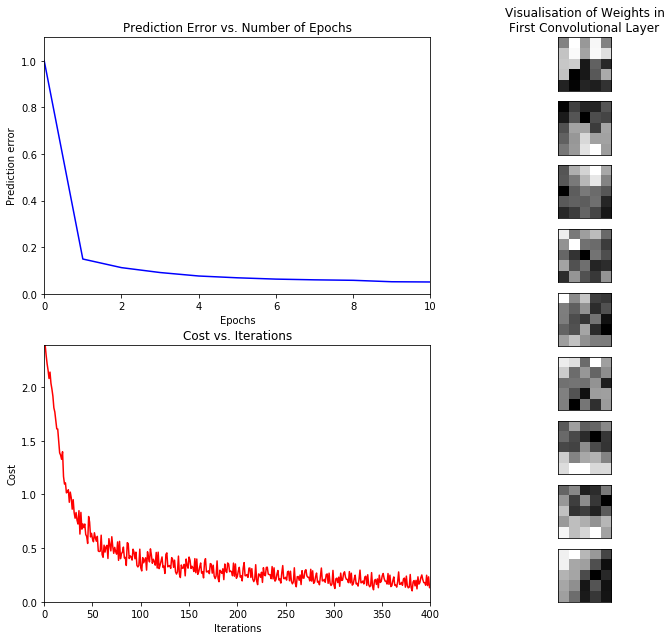

In [17]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 150
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 60 batches, test: 20 batches, validation: 20 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 5.350000 %


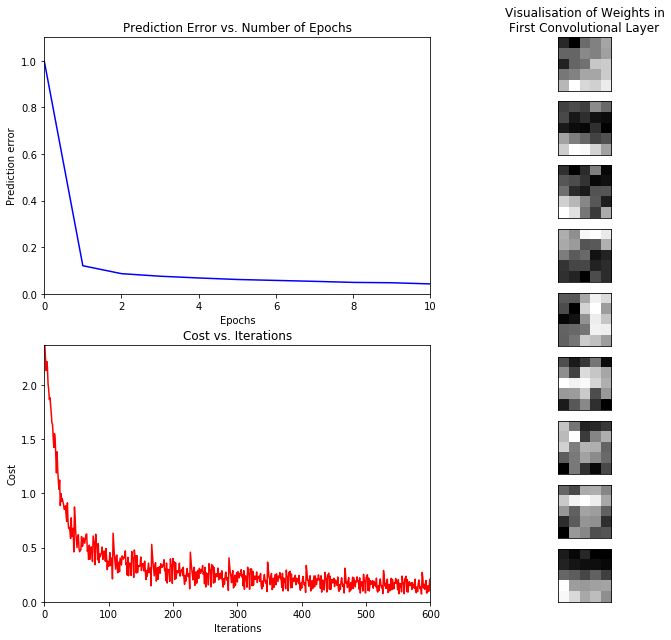

In [18]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 100
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

### Conclusions

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 240 batches, test: 80 batches, validation: 80 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 3.100000 %


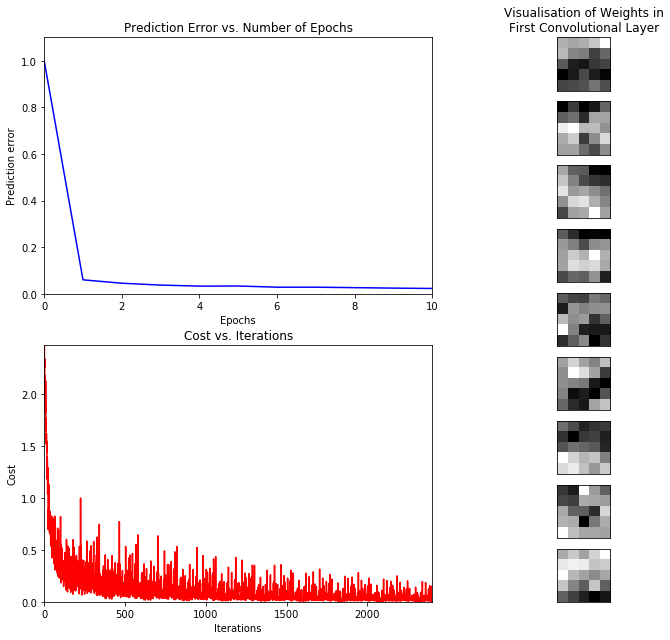

In [19]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 25
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

Replace this text with the details and discussions on the individual experiments that you performed and final conclusions on them all.

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 10 batches, test: 3 batches, validation: 3 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 10.222222 %


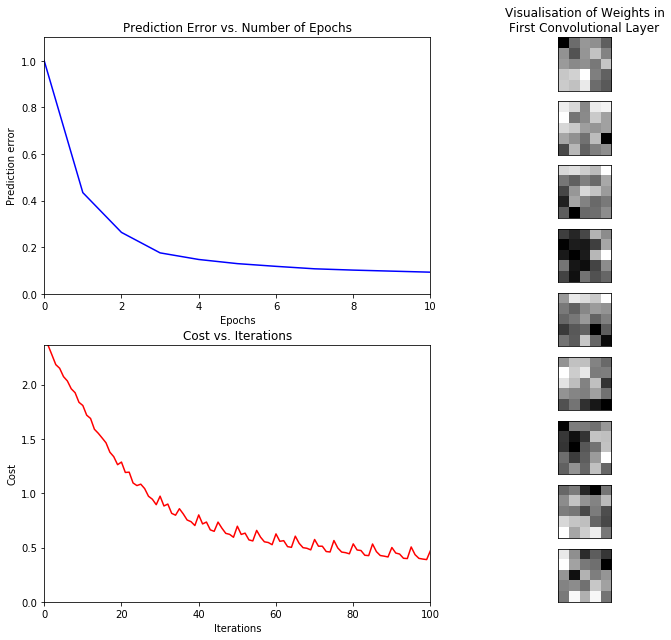

In [20]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 600
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 120 batches, test: 40 batches, validation: 40 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 17.750000 %


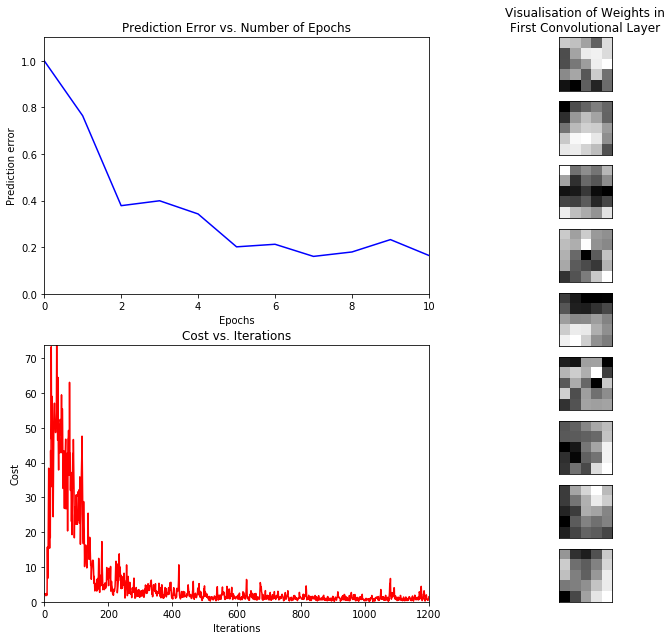

In [21]:
learning_rate   = .5
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 50
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 120 batches, test: 40 batches, validation: 40 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 4.650000 %


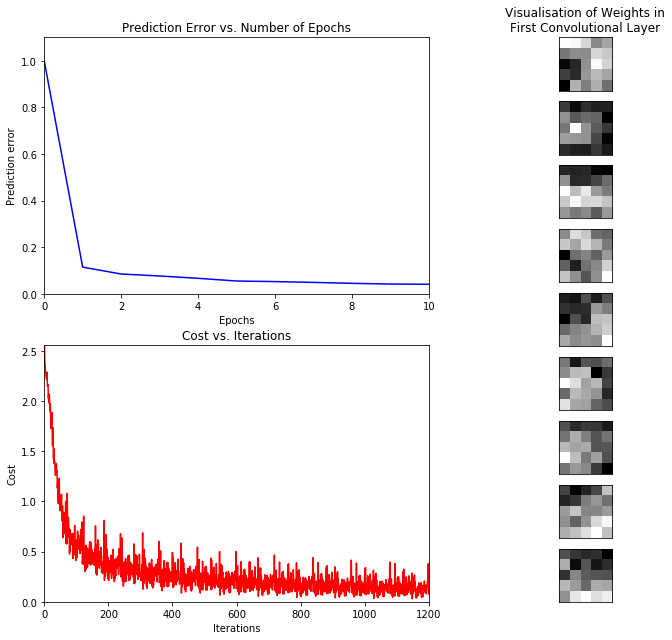

In [23]:
learning_rate   = .05
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 50
activation      = T.tanh
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 2000 samples
train: 120 batches, test: 40 batches, validation: 40 batches
***** Constructing model ***** 
***** Training model *****
***** Training Complete *****
Prediction error: 2.800000 %


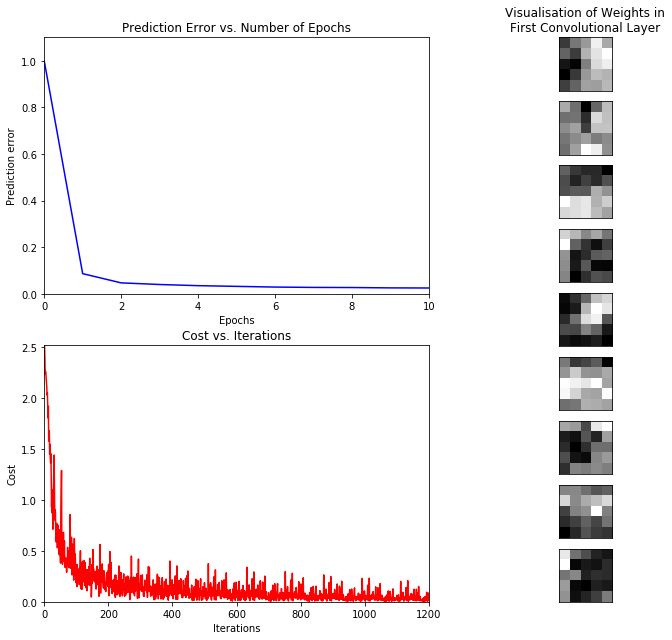

In [25]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 50
activation      = T.nnet.relu
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

In [ ]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 200
activation      = T.nnet.relu
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

In [ ]:
learning_rate   = .1
num_epochs      = 20
num_filters     = [9,16,16]
mini_batch_size = 50
activation      = T.nnet.relu
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)

In [ ]:
learning_rate   = .1
num_epochs      = 10
num_filters     = [9,16,16]
mini_batch_size = 25
activation      = T.nnet.relu
train_size      = 6000

###########################################################

# Loading dataset
# We use only a subset of the full dataset.
# Validation and test sets will be 1/3 of train 
# set size
datasets = load_data('mnist.pkl.gz', train_size)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

# Beginning the training process
train_test_conv_net(learning_rate, num_epochs,
                    num_filters, mini_batch_size, activation)